In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask.distributed import LocalCluster, Client

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter, temporal_train_test_split
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error, MeanAbsoluteScaledError, mean_absolute_scaled_error

SEED=0
np.random.seed(SEED)

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [8]:
forecasting_horizon = 30
fh = list(range(1, forecasting_horizon+1))

In [33]:
def load_and_preprocess_daily_data(start_index, end_index):
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="mean")
    esios_df = esios_provider.get_all_series(freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="sum")
    ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", start_index=start_index, end_index=end_index)
    coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", start_index=start_index, end_index=end_index)
    co2_df = icap_provider.get_series(icap_tickers[0], freq="D", start_index=start_index, end_index=end_index)

    contamination = 0.01
    esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
    lags = []
    date_features = ["day", "day_of_week", "week_of_year", "month"]

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)
    y_date_features = df_date_features.iloc[:, 0]
    X_date_features = df_date_features.iloc[:, 1:]

    y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test = temporal_train_test_split(y_date_features, X_date_features, test_size=forecasting_horizon)

    return y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test

In [34]:
y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test = load_and_preprocess_daily_data(start_index="2021-04-01", end_index="2023-03-31")

In [63]:
model = GradientBoostingRegressor()
forecaster = make_reduction(model, strategy="recursive", window_length=7)

forecaster.fit(y=y_date_features_train, X=X_date_features_train, fh=[1])

RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor(),
                                     window_length=7)

In [64]:
y_pred = forecaster.predict(X=X_date_features_test)

(<Figure size 4800x1200 with 1 Axes>,
 <AxesSubplot:ylabel='PRECIO_MERCADO_SPOT_DIARIO'>)

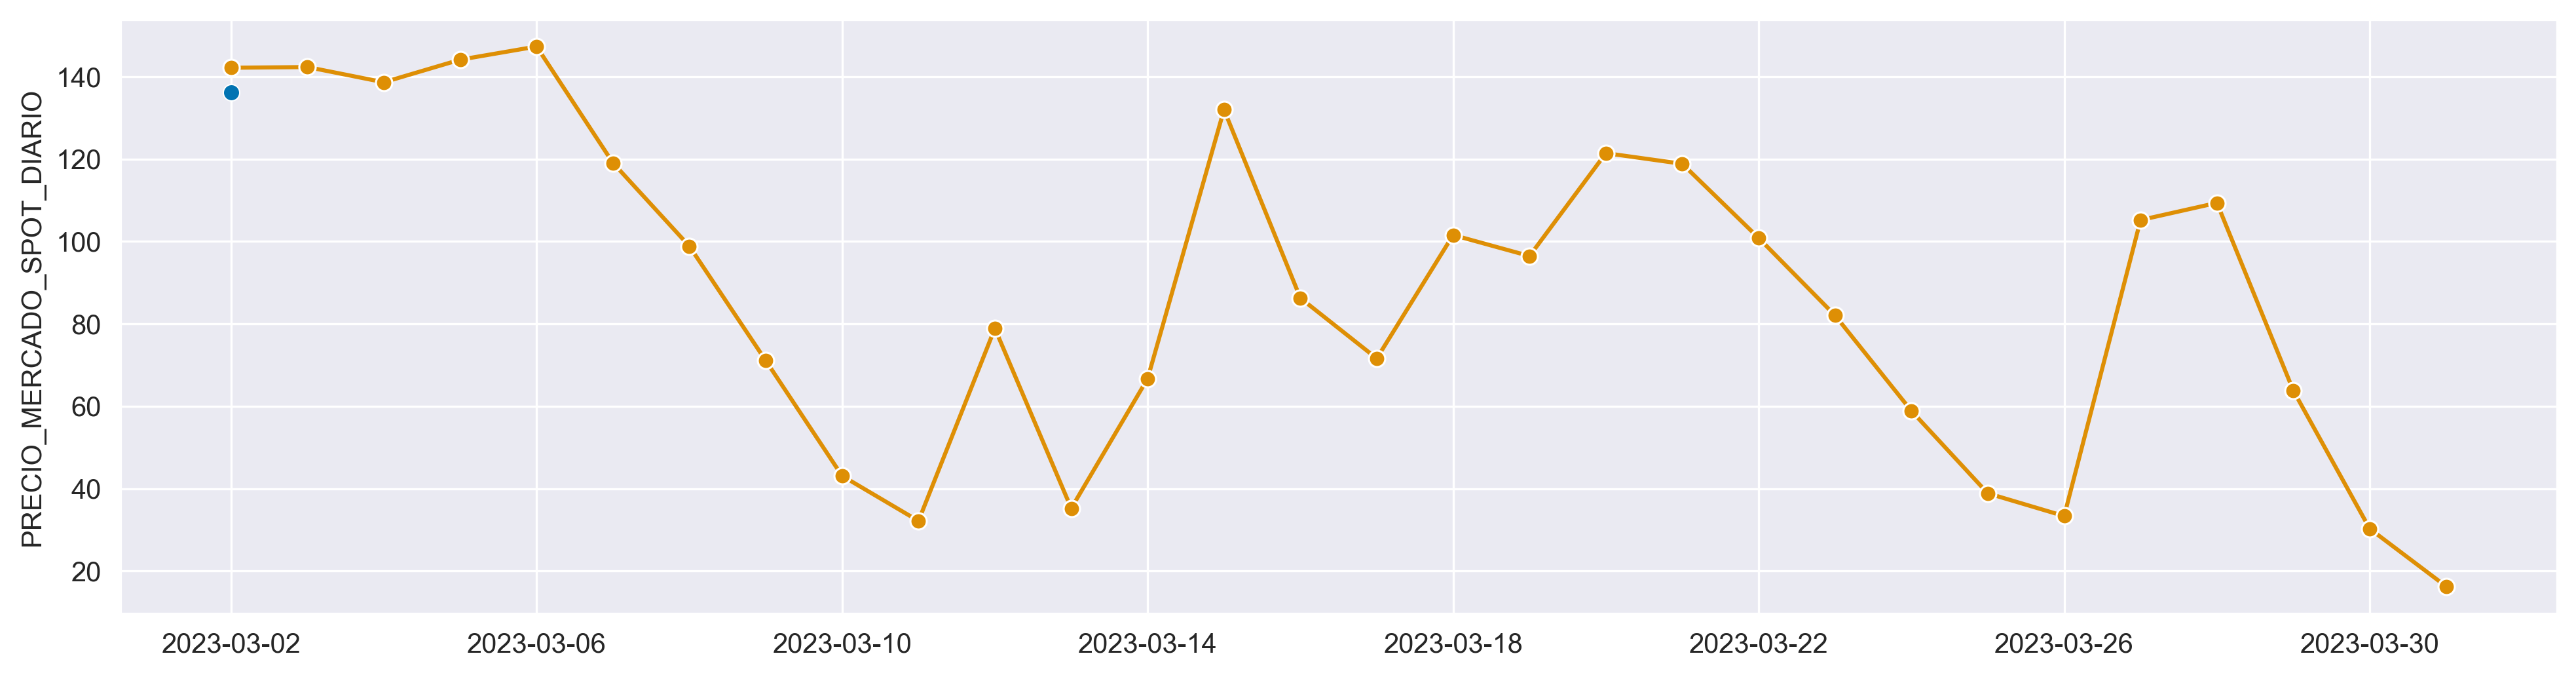

In [65]:
plot_series(y_pred, y_date_features_test)